# Breast Cancer Detection based on Histopathology Images

## About the Data:

- **Data Source:** https://www.kaggle.com/code/nasrulhakim86/breast-cancer-histopathology-images-classification/data
- The Breast Cancer Histopathological Image Classification (BreakHis) is composed of 9,109 microscopic images of breast tumor tissue collected from 82 patients.
- The images are collected using different magnifying factors (40X, 100X, 200X, and 400X). 
- To date, it contains 2,480 benign and 5,429 malignant samples (700X460 pixels, 3-channel RGB, 8-bit depth in each channel, PNG format).
- This database has been built in collaboration with the P&D Laboratory – Pathological Anatomy and Cytopathology, Parana, Brazil (http://www.prevencaoediagnose.com.br). 
- Each image filename stores information about the image itself: method of procedure biopsy, tumor class, tumor type, patient identification, and magnification factor. 
- For example, SOBBTA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<!-- shutil.rmtree("../Cancer/")
shutil.rmtree("../Cancer_train/")
shutil.rmtree("../Cancer_test/")
shutil.rmtree("../Cancer_validation/") -->

In [3]:
os.getcwd()

'd:\\BreaKHis_v1'

shutil.rmtree("./Cancer/")

In [4]:
#Loading the text file
fold_df = pd.read_csv("/Folds.csv")

**Folds.csv**

1. Folds.csv contains all the information about the patient images.
2. Folds.csv consists of the magnifying factor of the image. the exact path where the image is stores.
3. So, We can extract useful information from the filename.
4. Here Folds.csv plays major role in designing the system.

In [5]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [6]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

,fold,mag,grp,path
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

**Info:**

- From the path column we can extract the exact file name using apply and split functions on the path column.
- And also the class is extracted.

In [8]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [9]:
fold_df.head(3)

,fold,mag,grp,path,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign


**Creating New Directiory Cancer**

- The given data consists of very complex structure of folders where it stores the images.
- The structure as follows:
    - BreaKHis_v1
        - histology_slides
            - breast
                - **benign**
                    - **SOB**
                        - Type
                            - **patient_id**  
                                - 40x
                                - 100x
                                - 200x
                                - 400x
                - **malignant**
                    - **SOB**
                        - Type
                            - **patient_id**   
                                - 40x
                                - 100x
                                - 200x
                                - 400x
- To make things simple, using the exact path of the images, all the images are moved to the common folder called **Cancer.**
- Images are renamed with their class and patient_id.
                

In [10]:
#Creating new directory
os.makedirs("./Cancer/")

In [13]:
#Moving all the images to one folder
for p in fold_df['path']:
    src = "D:/BreaKHis_v1/" + p
    dest = "./Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)    

In [14]:
#Checking the len
len(os.listdir("./Cancer/"))

7909

- All the images are now stores in single folder.

In [15]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [16]:
#Printing the head to display the changed made
fold_df.head(3)

,fold,mag,grp,path,filename,label,file_loc,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign,benign_SOB_B_A-14-22549AB-100-003.png,0


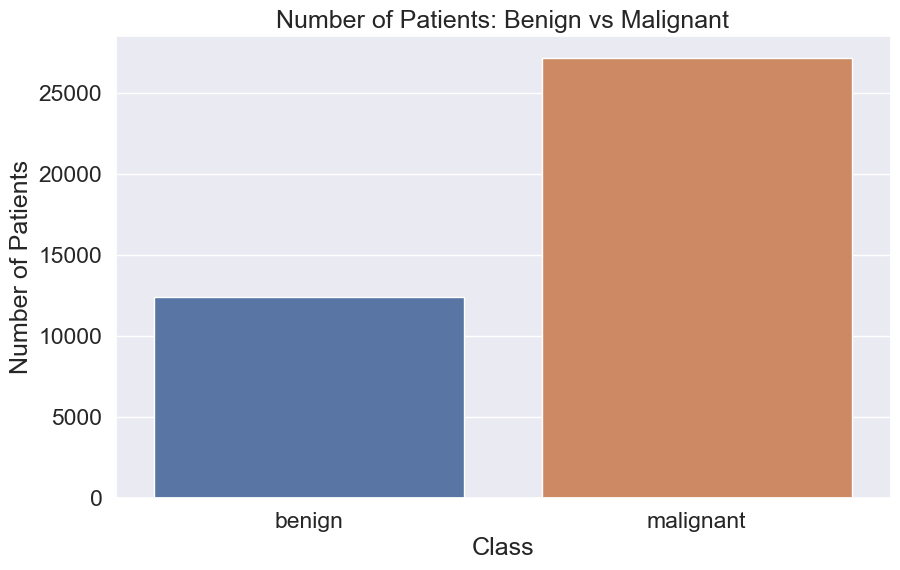

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming fold_df['label'] is correctly loaded and contains 'benign' and 'malignant'
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Ensure the 'label' column is correctly treated as categorical
fold_df['label'] = fold_df['label'].astype('category')

# Create the countplot
sns.countplot(x='label', data=fold_df)

plt.xlabel("Class")
plt.ylabel("Number of Patients")
plt.title("Number of Patients: Benign vs Malignant")
plt.show()


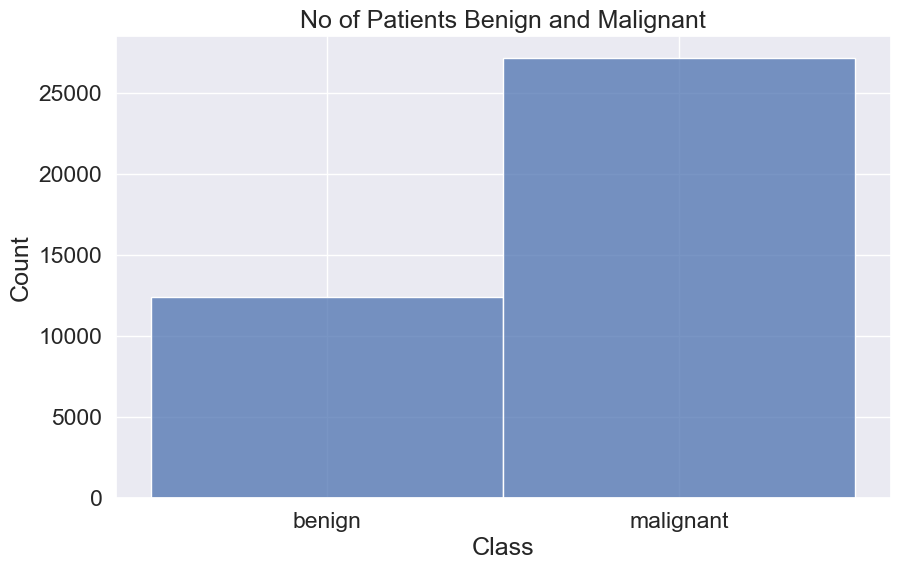

In [15]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.histplot(fold_df['label']);
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

- Data is Highly Imabalanced as this is the case with the real world.
- Medical datas are usually imbalanced because of their nature.

In [16]:
#Filtering the data frame to benign and malignant for visualization
benign_df = fold_df[fold_df['label'] == 'benign']
malignant_df = fold_df[fold_df['label'] == 'malignant']

# Benign Samples

In [ ]:
# #Plotting the benign samples
# plt.figure(figsize = (30,10))
# for i in range(0,40):
#     plt.subplot(4,10,i+1)
#     img = cv2.imread("./Cancer/"+ benign_df['file_loc'][i],1)
#     plt.imshow(img)

# Malignant Samples

In [ ]:
# #Plotting the malignant samples
# images = malignant_df['file_loc'].values
# plt.figure(figsize = (30,10))
# for i in range(0,40):
#     plt.subplot(4,10,i+1)
#     img = cv2.imread("./Cancer/"+ images[i],1)
#     plt.imshow(img)

**Findings:**

- From the above images there is very little to no difference between malignant and benign samples.
- This might be because we are not the pathologists, That's the original purpose of the detection system.
- Thus it makes it easy in the absence of actual pathologists.

In [64]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir("./Cancer/"))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[0])
df['class'] = df['label'].apply(lambda x: 0 if x =='benign' else 1)
df.set_index("file_loc",inplace=True)

In [65]:
#Checking the data frame
df.head(2)

,label,class
file_loc,,
adenosis_SOB_B_A-14-22549AB-100-001.png,adenosis,1
adenosis_SOB_B_A-14-22549AB-100-002.png,adenosis,1


- Using the data frame, the splitting for train, test and validation is done.
- 10% is kept aside as the test data, and 10% as validation data.
- 80% is taken as the training data.

In [66]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.1, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.1, random_state = 47)

In [67]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (6406, 2)
Validation size : (712, 2)
Testing size : (791, 2)


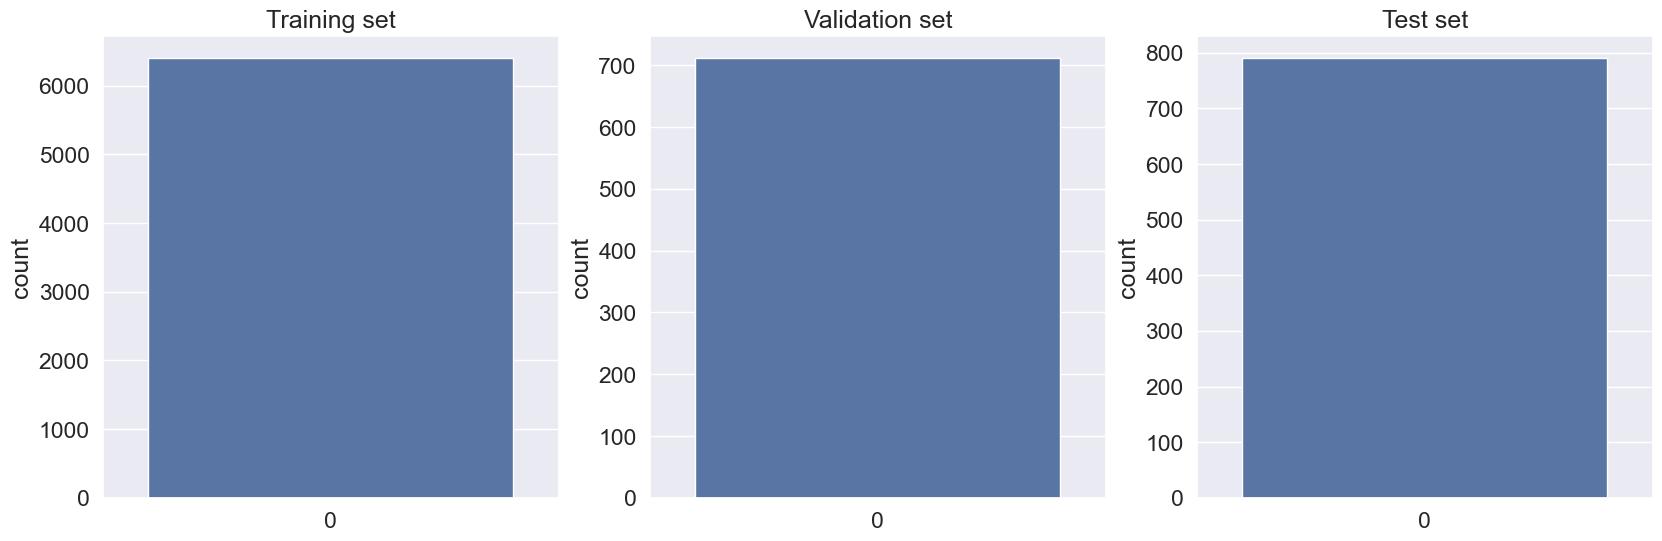

In [68]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

- Training , Validation and Testing data is pretty imbalanced as this is the case in the real world.
- Here the validation and testing set is left as it is, because it should reflects the real world scenario.
- And the training data is balanced by oversampling the minority class(Benign).

In [35]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [38]:
train_has_cancer.shape

(6406, 2)

In [39]:
train_has_no_cancer.shape

(0, 2)

In [40]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), 
                                     random_state = 47, replace = True)

ValueError: high <= 0

In [41]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

NameError: name 'train_has_no_cancer_upsample' is not defined

- As expected the training data is balanced.

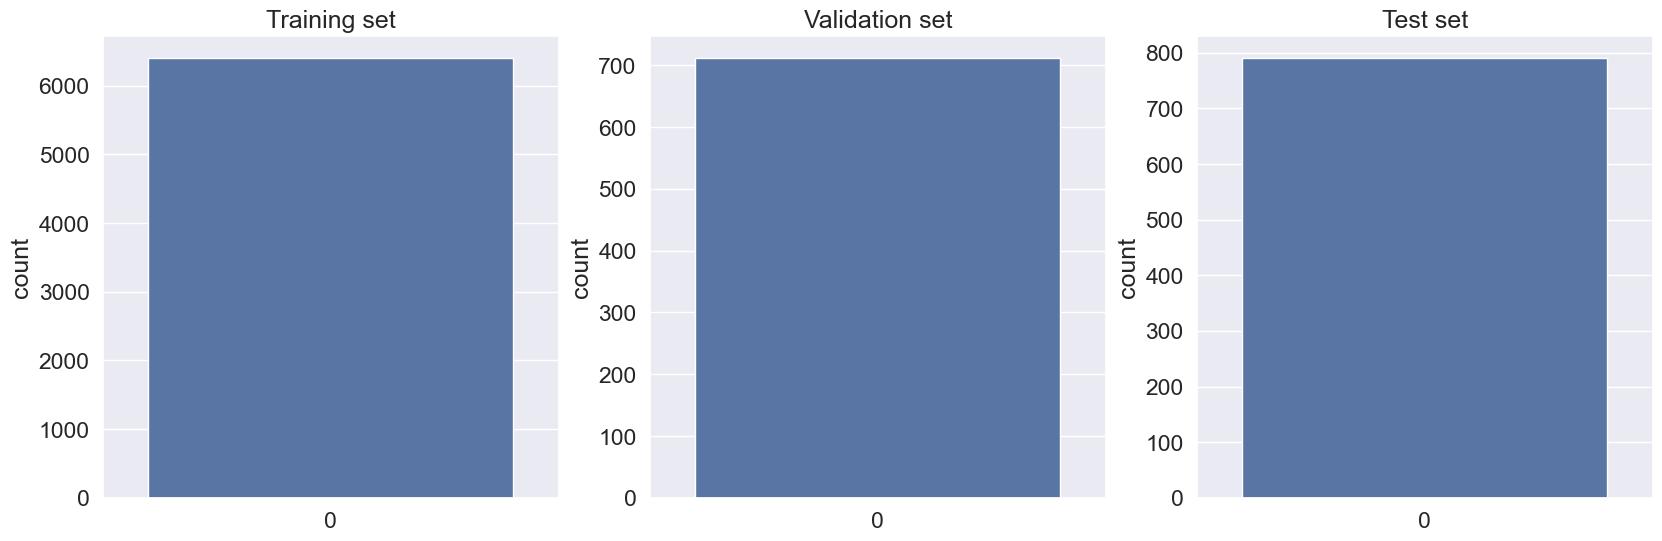

In [42]:
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test['class']);
plt.title("Test set");

## Creating the directory structure for Training , Validation and Testing:

- Earlier all the images where stored in the single directory called Cancer.
- Now we are using Image data generator as part of our algorithm designing.
- Image data generator expects the Images to be in the following structure:
    - **Train**
        - Benign
        - Malignant
    - **Validation**
        - Benign
        - Malignant
    - **Testing**
        - Benign
        - Malignant
- Above structure is the prerequisite for the Image Data Generator to run.
        

In [44]:
#Creating the directories to store images
os.makedirs("./Cancer_train")
os.makedirs("./Cancer_test")
os.makedirs("./Cancer_validation")
os.makedirs("./Cancer_train/benign")
os.makedirs("./Cancer_train/malignant")
os.makedirs("./Cancer_validation/benign")
os.makedirs("./Cancer_validation/malignant")
os.makedirs("./Cancer_test/benign")
os.makedirs("./Cancer_test/malignant")

- Using the above directories and the splitted data frames data_train, data_val, data_test.
- We are moving the images to the corresponding directories based on the class of the image(Benign or Malignant).

In [45]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:          
            label = 'benign'      
        src = os.path.join("../Cancer/",img)
        dest = os.path.join("../Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img data type = object is not supported
>  - Expected Ptr<cv::UMat> for argument 'img'


In [32]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

In [33]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join("../Cancer/",img)
    dest = os.path.join("../Cancer_test/",label,img)
    shutil.copyfile(src,dest)

In [34]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("../Cancer_train/benign/")))
print("Malignant::",len(os.listdir("../Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("../Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("../Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_test/malignant/")))

Training Data:
 
Benign: 4398
Malignant:: 4398
 
Validation Data
 
Benign size: 211
Malignant size : 501
 
Testing Data:
 
Benign size : 261
Malignant size : 530


- Training data is balanced.
- Testing and Validation data is kept as such to reflect the real scenario.

## Image Data Generator

- Reference:  https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [35]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

- Here the **Image Data Generator** is defined with following functions:
    - Random rotation by 20 degrees.
    - Horizontal flip.
    - Vertical flip.
    - Rescale image by its pixel value.
    - Randomly Zoom image by 20%.
    - Random shear by 20%.

**Flow from Directory**
- Earlier Image folders where created as per the prerequisite.
- Here the flow_from_directory will find the number of images and their classes based on the hierarchy.
- Size of the image is set to 128x128.
- Batch size of 32 and class mode of binary(Benign or Malignant).

In [36]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("../Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("../Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 8796 images belonging to 2 classes.
Found 712 images belonging to 2 classes.


# CNN Architecture 

- CNN architecture is defined using **Conv2D layers and Maxpooling layers.**
- Dropout Layers are added to randomly turn off some neurons while training to prevent from overfitting.
- Flatten layer is added at the end to form Dense Layers.
- **relu** is used as activation in all the layers and **Sigmoid** as the activation in the output layer.

In [37]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

2022-08-06 22:36:18.645464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 22:36:18.769366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 22:36:18.770198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0

2022-08-06 22:36:18.781927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-06 22:36:18.782269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 22:36:18.783068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 22:36:18.783836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [38]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

## **Model Compilation**

- Model is compiled by using binary crossentropy as the loss function and adam optimizer to optimize the weights.
- Early stopping is involved to monitor validation loss inorder to prevent overfitting with patience level = 5
- Modelcheckpoint is used to store the best models for every epoch.

In [39]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

## Model Fit 

- Model is fitted using train and validation generators generated using Image DataGenerator.
- Verbose is set to 1 to monitor accuracy and losses.
- Model is trained for 200 epochs.
- early stopping and checkpoint are used as the call backs.

In [40]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

2022-08-06 22:36:23.776528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-08-06 22:36:26.686957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


275/275 [==============================] - 163s 562ms/step - loss: 0.5243 - accuracy: 0.7592 - val_loss: 0.4595 - val_accuracy: 0.8385


2022-08-06 22:39:07.363499: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/200
275/275 [==============================] - 130s 474ms/step - loss: 0.4737 - accuracy: 0.7974 - val_loss: 0.5681 - val_accuracy: 0.7626
Epoch 3/200
275/275 [==============================] - 124s 450ms/step - loss: 0.4286 - accuracy: 0.8146 - val_loss: 0.4818 - val_accuracy: 0.8301
Epoch 4/200
275/275 [==============================] - 125s 454ms/step - loss: 0.4273 - accuracy: 0.8190 - val_loss: 0.4718 - val_accuracy: 0.8118
Epoch 5/200
275/275 [==============================] - 126s 457ms/step - loss: 0.4057 - accuracy: 0.8224 - val_loss: 0.3898 - val_accuracy: 0.8652
Epoch 6/200
275/275 [==============================] - 125s 454ms/step - loss: 0.3681 - accuracy: 0.8411 - val_loss: 0.3957 - val_accuracy: 0.8539
Epoch 7/200
275/275 [==============================] - 124s 450ms/step - loss: 0.3558 - accuracy: 0.8496 - val_loss: 0.3605 - val_accuracy: 0.8567
Epoch 8/200
275/275 [==============================] - 125s 455ms/step - loss: 0.3371 - accuracy: 0.8632 - val_loss: 0

## Model Results 

- The model is terminated after 49 epochs as it started overfitting.
- The model is terminated by Early stopping.
- The results are promising as the training accuracy is 93% while validation accuracy is 91.8%.

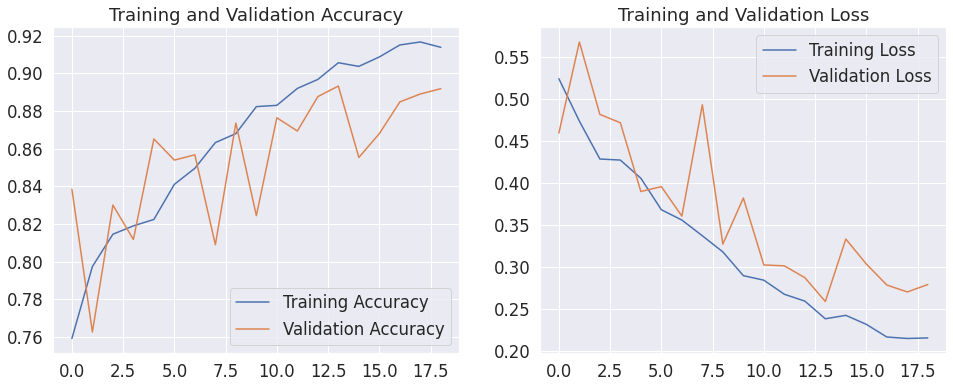

In [41]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation on Test Data 

In [42]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)

Found 791 images belonging to 2 classes.


In [43]:
pred = cancer_model.evaluate(test_gen)

791/791 [==============================] - 17s 21ms/step - loss: 0.2402 - accuracy: 0.9077


- **Our CNN model is 91.5% accurate in predicting the cancer using the histopathology Images.**

In [44]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("../Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
    #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255.   

In [45]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

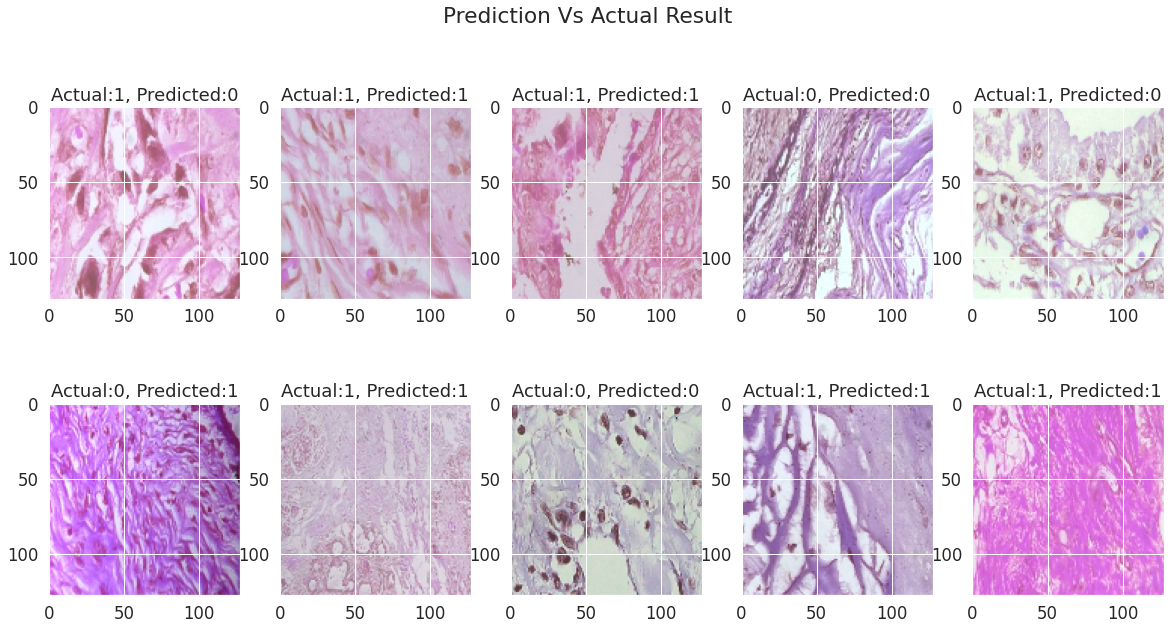

In [46]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)

# Deployed Model

The Model is deployed in the below link!!

[Breast Cancer Detection App - Click here](https://nascent-bot-cancer-app-myappwelcome-i66wjm.streamlitapp.com)

# Time to UpVote!! Thank You!!